# Global Vectors for Word Representations
## Skip-Gram Recap
Let's recap the summary of Skip-Gram model. 

1. Go through each word of the whole corpus, suppose that `W` is the total number of words in the corpus, aka the vocabulary size. 

2. Predict surrounding words of each (window's center) word. The bottom sum can be computationally expensive cause it must go through the whole entire vocabulary.

$$
P(o \mid c) = \frac{exp(u_{o}^{T} v_{c})}{\sum^{W}_{w=1} exp(u_{w}^{T}v_{c})}
$$

3. Take gradients at each such window for SGD

There are two matrices, `V` and `U`. We will use upper cased letters to represent matrices and lower cased letters to represent a vector. Use `D` as the word vector feature dimension.

`V` is the center word matrix. Notice that each column represents the word vector for one single word in the corpus.

$$
V = \begin{bmatrix} 
V[0]_{0} & V[0]_{1} & ... & V[0]_{W} \\
V[1]_{0} & V[1]_{1} & ... & V[1]_{W} \\
... & ... & ... & ... \\
V[D]_{0} & V[D]_{1} & ... & V[D]_{W}
\end{bmatrix}
$$

`U` is the context word or outside word matrix. Similarly, each column represents the word vector for a single word in the corpus.

$$
U = \begin{bmatrix} 
U[0]_{0} & U[0]_{1} & ... & U[0]_{W} \\
U[1]_{0} & U[1]_{1} & ... & U[1]_{W} \\
... & ... & ... & ... \\
U[D]_{0} & U[D]_{1} & ... & U[D]_{W}
\end{bmatrix}
$$

**Objective**: We want to maximize the probability for each outside word, given a center word.

## Distributed Representations of Words and Phrases and Their Compositionality
The sum under probabiltity expression is very expensive and inefficient because for a given center word, most context words in the corpus are completely irrelevant to it. The dot product of two irrelevant words leads to zero contribution to the sum. 

*The trick here is to train binary logistic regressions for a true pair (center word and word in its context window) versus a couple of noise pairs (the center word paired with a random word.)*

### Objective Function
`T` is the total number of windows that we can possibly fit in a corpus given a window size. 

$$
J(\theta) = \frac{1}{T} \sum_{t=1}^{T} J_{t}(\theta)
$$

And the simplified cost function (which is a bit different from previous lecture) for a time step or also known as a given window is

$$
J_{t}(\theta) = log \; \sigma(u_{o}^{T}v_{c}) + \sum_{j \tilde{} P(w)} \left [ log \; \sigma(-u_{j}^{T}v_{c})\right ]
$$

1. First term is using a sigmoid function instead of a typical probability notation because it is computationally easier to compute a sigmoid. The result will come out to be the same after maximization. 
2. The second term represents sub-sampling. We take `k` negative examples, i.e. random words that do not appear with the center word. 
3. Maximize probability that real outside word appears and minimize probability that random words appear around center word.

### Subsampling Rule
#### Math Trick
$$
\sigma(-x) = 1 - \sigma(x)
$$

#### Unigram Distribution `U(w)`
The way we sample the random words are using unigram distribution `U(w)` raised to the $\frac{3}{4}$ power. The power term makes less frequent words to be sampled more often. The unigram distribution function will be discussed later.

$$
P(w) = \frac{U(w)^{3/4}}{Z}
$$



## Count Based Approach
Essentially the Skip-Gram model is capturing coocurrence of words one at a time. It answers the question how often do words appear next to each other. It's natural to think that, why not just use coocurrence matrix on words? For example, I have the following corpus.
```
I like deep learning.
I like NLP.
I enjoy driving.
```

Let's assume a window size of 1, which means we only count the nearest word. For example, if I have **I**, then I look at its neighboring word and do the count. In this case, the count for **like** is 2 because it appears twice near **I**.

| counts   | I | like | enjoy | deep | learning | NLP | driving |
|----------|---|------|-------|------|----------|-----|---------|
| I        | 0 | 2    | 1     | 0    | 0        | 0   | 0       |   
| like     | 2 | 0    | 0     | 1    | 0        | 1   | 0       |
| enjoy    | 1 | 0    | 0     | 0    | 0        | 0   | 1       |
| deep     | 0 | 1    | 0     | 0    | 1        | 0   | 0       |
| learning | 0 | 0    | 0     | 1    | 0        | 0   | 0       |
| NLP      | 0 | 1    | 0     | 0    | 0        | 0   | 0       |
| driving  | 0 | 0    | 1     | 0    | 0        | 0   | 0       |

There are couple disadvantages to doing this. 

* Increase in size with vocabulary
* Very high dimensional because it is the square of vocabulary size
* Subsequent classification models have sparsity issues

However we can address those disadvantages with low dimensional vectors.

* Store most of the important information in a fixed, small number of dimensions: a dense vector
* Ideal dimension is probably around 25 ~ 1000
* Reduce dimensionality using SVD

U shape: (7, 7), singular values shape: (7,), V shape: (7, 7)
[2.64  2.64  1.193 1.193 0.778 0.778 0.   ]


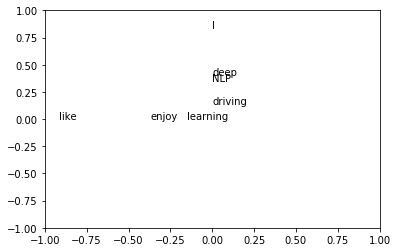

In [16]:
import numpy as np
import matplotlib.pyplot as plt

words = ["I", "like", "enjoy", "deep", "learning", "NLP", "driving"]
X = np.array([
    [0, 2, 1, 0 ,0 ,0 ,0],
    [2, 0, 0, 1, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 1],
    [0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0]
])

U, s, V = np.linalg.svd(X)

print "U shape: %s, singular values shape: %s, V shape: %s" % (U.shape, s.shape, V.shape)
print np.round(s, decimals=3)

for i in xrange(len(words)):
    plt.text(U[i, 0], U[i, 1], words[i])

plt.axis([-1, 1, -1, 1])
plt.show()

The first two columns of U corresponding to the 2 biggest singular values. There are many optimizations we can do to the SVD model. Certain words are too frequently appeared in the model. We can clamp the occurence to a maximum of 100 count or we can simply ignore them all. We can also use Pearson correlations instead of direct counts.

The problem with SVD:
* Computational cost scales quadratically, which is very bad for millions of words or documents.
* Hard to incorporate new words or documents.

| Count-based Approach: LSA, HAL, COALS, Hellinger-PCA | Direct Prediction: Skip-gram, NNLM, HLBL, RNN |
|------------------------------------------------------|-----------------------------------------------|
| Fast training | Scale with corpus size |
| Efficient usage of statistics | Inefficient usage of statistics |
| Primarily used to capture word similarity | Generate improved performance on other tasks |
| Disproportionate importance given to large counts | Can capture complex patterns beyond word similarity |

## Best of Both Worlds: GloVe
*Pennington, Socher, Manning (2014)*

$$
J(\theta) = \frac{1}{2} \Sigma_{i, j = 1}^{W} f(P_{ij})(u_{i}^{T}v_{j} - log\; P_{ij})^{2}
$$

* Fast training
* Scalable to huge corpora
* Good performance even with small corpus, and small vectors